In [6]:
import numpy as np
import random
import pandas as pd
import pickle
import os
from tqdm import tqdm
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [7]:
!pip install kaggle

In [8]:
!mkdir ~/.kaggle

In [12]:
!cp kaggle.json ~/.kaggle/

In [13]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d monogenea/birdsongs-from-europe

100% 7.45G/7.46G [02:30<00:00, 64.8MB/s]
100% 7.46G/7.46G [02:30<00:00, 53.3MB/s]


In [15]:
!unzip /content/birdsongs-from-europe.zip

Archive:  /content/birdsongs-from-europe.zip
  inflating: metadata.csv            
  inflating: mp3/Acrocephalus-arundinaceus-131536.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-136005.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178787.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178789.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178791.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178792.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178793.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178869.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-178959.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-181959.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-181961.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-215604.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-215950.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-233487.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-240480.mp3  
  inflating: mp3/Acrocephalus-arundinaceus-267175.mp3  
  inflating: mp3/Acro

In [16]:
!rm birdsongs-from-europe.zip

## Construction du Dataset

In [17]:
metadata = pd.read_csv("/content/metadata.csv")
espece = pd.unique(metadata['Species'])[1:4]

In [18]:
#Construction des chunks de chant d'oiseau à partir des mp3
from Music_VAE_Generation.decoupe import find_chunks, reconstruct_chunks

for bird in espece:
  data = metadata[metadata['Species']==bird]

  data.index = range(data.shape[0])
  for song_num in tqdm(range(data.shape[0])):
      path_file = "/content/mp3/" + data.loc[song_num]['Path'].split('/')[-1]
      id_song = str(data['Recording_ID'].loc[song_num])
      chunks = find_chunks(path_file, 500, -32)
      reconstruct_chunks(chunks, bird + "/song/", id_song)

100%|██████████| 43/43 [08:18<00:00, 11.60s/it]


## Preprocessing étape 2

In [19]:
!pip install mutagen

     |████████████████████████████████| 218 kB 12.1 MB/s 


In [20]:
import mutagen
from mutagen.wave import WAVE

#Problème des longueurs des enregistrements
def sup_enregistrement_court(dir):
  compteur_sup = 0
  songs = os.listdir(dir)
  for song in songs:
    audio = WAVE(dir + song)
    audio_info = audio.info
    if audio_info.length < 1.1 or audio_info.length > 5:
      os.remove(dir + song)
      compteur_sup+=1
  return compteur_sup

In [21]:
import scipy.signal as signal

In [22]:
sig, sr = librosa.load("/content/Parus major/song/1293238.wav")

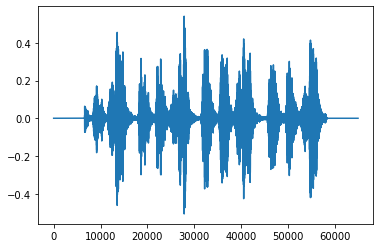

In [23]:
plt.plot(sig)

In [24]:
Audio(sig, rate = sr)

In [25]:
for specie in espece:
  sup_enregistrement_court("/content/"+ specie +"/song/")

In [26]:
from pydub import AudioSegment

def amplification(origin_path, export_path, amplification):
  song = AudioSegment.from_wav(origin_path)
  song = song + amplification
  song.export(export_path, format = "wav")

## Création des spectrograms

In [27]:
from Music_VAE_Generation.preprocess import Loader, Padder, LogSpectrogramExtractor, MinMaxNormaliser, Saver, PreprocessingPipeline

#Parametre de sauvegarde
FRAME_SIZE = 2048
HOP_LENGTH = 512
DURATION = 2.6
SAMPLE_RATE = 22050
MONO = True

MODEL_PATH = "./model/"

In [ ]:
for bird_name in espece:
  
  FILES_DIR = "./"+ bird_name +"/song/"
  if not os.path.exists("./"+ bird_name +"/spectrograms/"):
      os.mkdir("./"+ bird_name +"/spectrograms/")
  if not os.path.exists("./model/"):
      os.mkdir("./model/")
  SPECTROGRAMS_SAVE_DIR = "./"+ bird_name +"/spectrograms/"
  MIN_MAX_VALUES_SAVE_DIR = "./"+ bird_name +"/"

  loader = Loader(SAMPLE_RATE, DURATION, MONO)
  padder = Padder()
  log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
  min_max_normaliser = MinMaxNormaliser(0, 1)
  saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

  preprocessing_pipeline = PreprocessingPipeline()
  preprocessing_pipeline.loader = loader
  preprocessing_pipeline.padder = padder
  preprocessing_pipeline.extractor = log_spectrogram_extractor
  preprocessing_pipeline.normaliser = min_max_normaliser
  preprocessing_pipeline.saver = saver

  preprocessing_pipeline.process(FILES_DIR)

Processed file ./Fringilla coelebs/song/1774040.wav
Processed file ./Fringilla coelebs/song/4636261.wav
Processed file ./Fringilla coelebs/song/42619032.wav
Processed file ./Fringilla coelebs/song/5341003.wav
Processed file ./Fringilla coelebs/song/20572419.wav
Processed file ./Fringilla coelebs/song/16719717.wav
Processed file ./Fringilla coelebs/song/52824718.wav
Processed file ./Fringilla coelebs/song/16719720.wav
Processed file ./Fringilla coelebs/song/4261900.wav
Processed file ./Fringilla coelebs/song/17741420.wav
Processed file ./Fringilla coelebs/song/2052055.wav
Processed file ./Fringilla coelebs/song/1671978.wav
Processed file ./Fringilla coelebs/song/1776636.wav
Processed file ./Fringilla coelebs/song/2476394.wav
Processed file ./Fringilla coelebs/song/1411934.wav
Processed file ./Fringilla coelebs/song/2057240.wav
Processed file ./Fringilla coelebs/song/18428313.wav
Processed file ./Fringilla coelebs/song/53651720.wav
Processed file ./Fringilla coelebs/song/42619015.wav
Pro

In [ ]:
plt.figure(figsize=(15,8))
path_song = "./Parus major/song/1254481.wav"
path_spec = "/content/Parus major/spectrograms/1254481.wav.npy"
spec_graph = np.load(path_spec)
im = plt.imshow(spec_graph)
Audio(path_song)

## Entraînement du modèle

In [ ]:
from Music_VAE_Generation.auto_encoder import Autoencoder

LEARNING_RATE = 0.00025
BATCH_SIZE = 12
EPOCHS = 20

spec = os.listdir("./Fringilla coelebs/spectrograms")
taille_input = np.load('./Fringilla coelebs/spectrograms/' + spec[0]).shape

In [ ]:
#Ajouter set de validation
def load_music(species_name):
    x_train = []
    for specie in species_name:
      spectrograms_path = "./" + specie + "/spectrograms"
      
      for root, _, file_names in os.walk(spectrograms_path):
          for file_name in file_names:
              file_path = os.path.join(root, file_name)
              spectrogram = np.load(file_path) # (n_bins, n_frames)
              x_train.append(spectrogram)

    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]
    np.random.shuffle(x_train)
    return x_train

def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = Autoencoder(
        input_shape=(taille_input[0], taille_input[1], 1),
        conv_filters=(512,256, 128, 64, 32),
        conv_kernels=(3,3,3,3,2),
        conv_strides=(2,2,2,2, (2,1)),
        latent_space_dim=256
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    history = autoencoder.train(x_train, batch_size, epochs)
    return autoencoder, history

In [ ]:
x_train = load_music(espece)
autoencoder, history = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
autoencoder.save("model")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 1024, 112, 1 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 512, 56, 512) 5120        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 512, 56, 512) 0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_bn_1 (BatchNormalizatio (None, 512, 56, 512) 2048        encoder_leakyrelu_1[0][0]        
____________________________________________________________________________________________

KeyboardInterrupt: ignored

## Test

In [ ]:
spec_path = "./Parus major/spectrograms"

In [ ]:
if not os.path.exists("./original/"):
    os.mkdir("./original/")
if not os.path.exists("./generated/"):
    os.mkdir("./generated/")

In [ ]:
import soundfile as sf
from Music_VAE_Generation.preprocess import MinMaxNormaliser

SAVE_DIR_ORIGINAL = "./original/"
SAVE_DIR_GENERATED = "./generated/"
MIN_MAX_VALUES_PATH = "./Parus major/min_max_values.pkl"


def load_audio(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # -> (3000, 256, 64, 1)
    return x_train, file_paths


def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=2):
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_spectrograms)
    sampled_spectrogrmas = spectrograms[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                           file_paths]
    print(file_paths)
    print(sampled_min_max_values)
    return sampled_spectrogrmas, sampled_min_max_values


def save_signals(signals, save_dir, sample_rate=22050):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

In [ ]:
class SoundGenerator:
    def __init__(self, autoencoder, hop_length):
        self.autoencoder=autoencoder
        self.hop_length = hop_length
        self._min_max_normaliser = MinMaxNormaliser(0, 1)

    def generate(self, spectrograms, min_max_values):
        generated_spectrograms, latent_representations = self.autoencoder.reconstruct(spectrograms)
        signals = self.convert_spectrograms_to_audio(generated_spectrograms, min_max_values)
        return signals, latent_representations

    def convert_spectrograms_to_audio(self, spectrograms, min_max_values):
        signals = []
        for spectrogram, min_max_value in zip(spectrograms, min_max_values):
            #reshape the log spectrograms
            log_spectrogram = spectrogram[:, :, 0]
            #apply denormalisation
            denorm_log_spec = self._min_max_normaliser.denormalise(log_spectrogram, min_max_value["min"], min_max_value["max"])
            #log spectrogram
            spec = librosa.db_to_amplitude(denorm_log_spec)
            #apply Griffin-Lin
            signal = librosa.istft(spec, hop_length=self.hop_length)
            #append signal to "signals"
            signals.append(signal)
        return signals

In [ ]:
autoencoder = Autoencoder.load("model")
sound_generator = SoundGenerator(autoencoder, HOP_LENGTH)

with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)

specs, file_paths = load_audio(spec_path)

sampled_specs, sampled_min_max_values = select_spectrograms(specs, file_paths, min_max_values, 5)
signals, _ = sound_generator.generate(sampled_specs, sampled_min_max_values)
orignal_signals = sound_generator.convert_spectrograms_to_audio(sampled_specs, sampled_min_max_values)

save_signals(signals, SAVE_DIR_GENERATED)
save_signals(orignal_signals, SAVE_DIR_ORIGINAL)

In [ ]:
Audio("./original/1.wav")

In [ ]:
Audio("./generated/1.wav")